In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import sys

sys.path.append('./src/')

from initial_conditions import lamb_dipole
from poisson import poisson
from animation import animation

%matplotlib inline

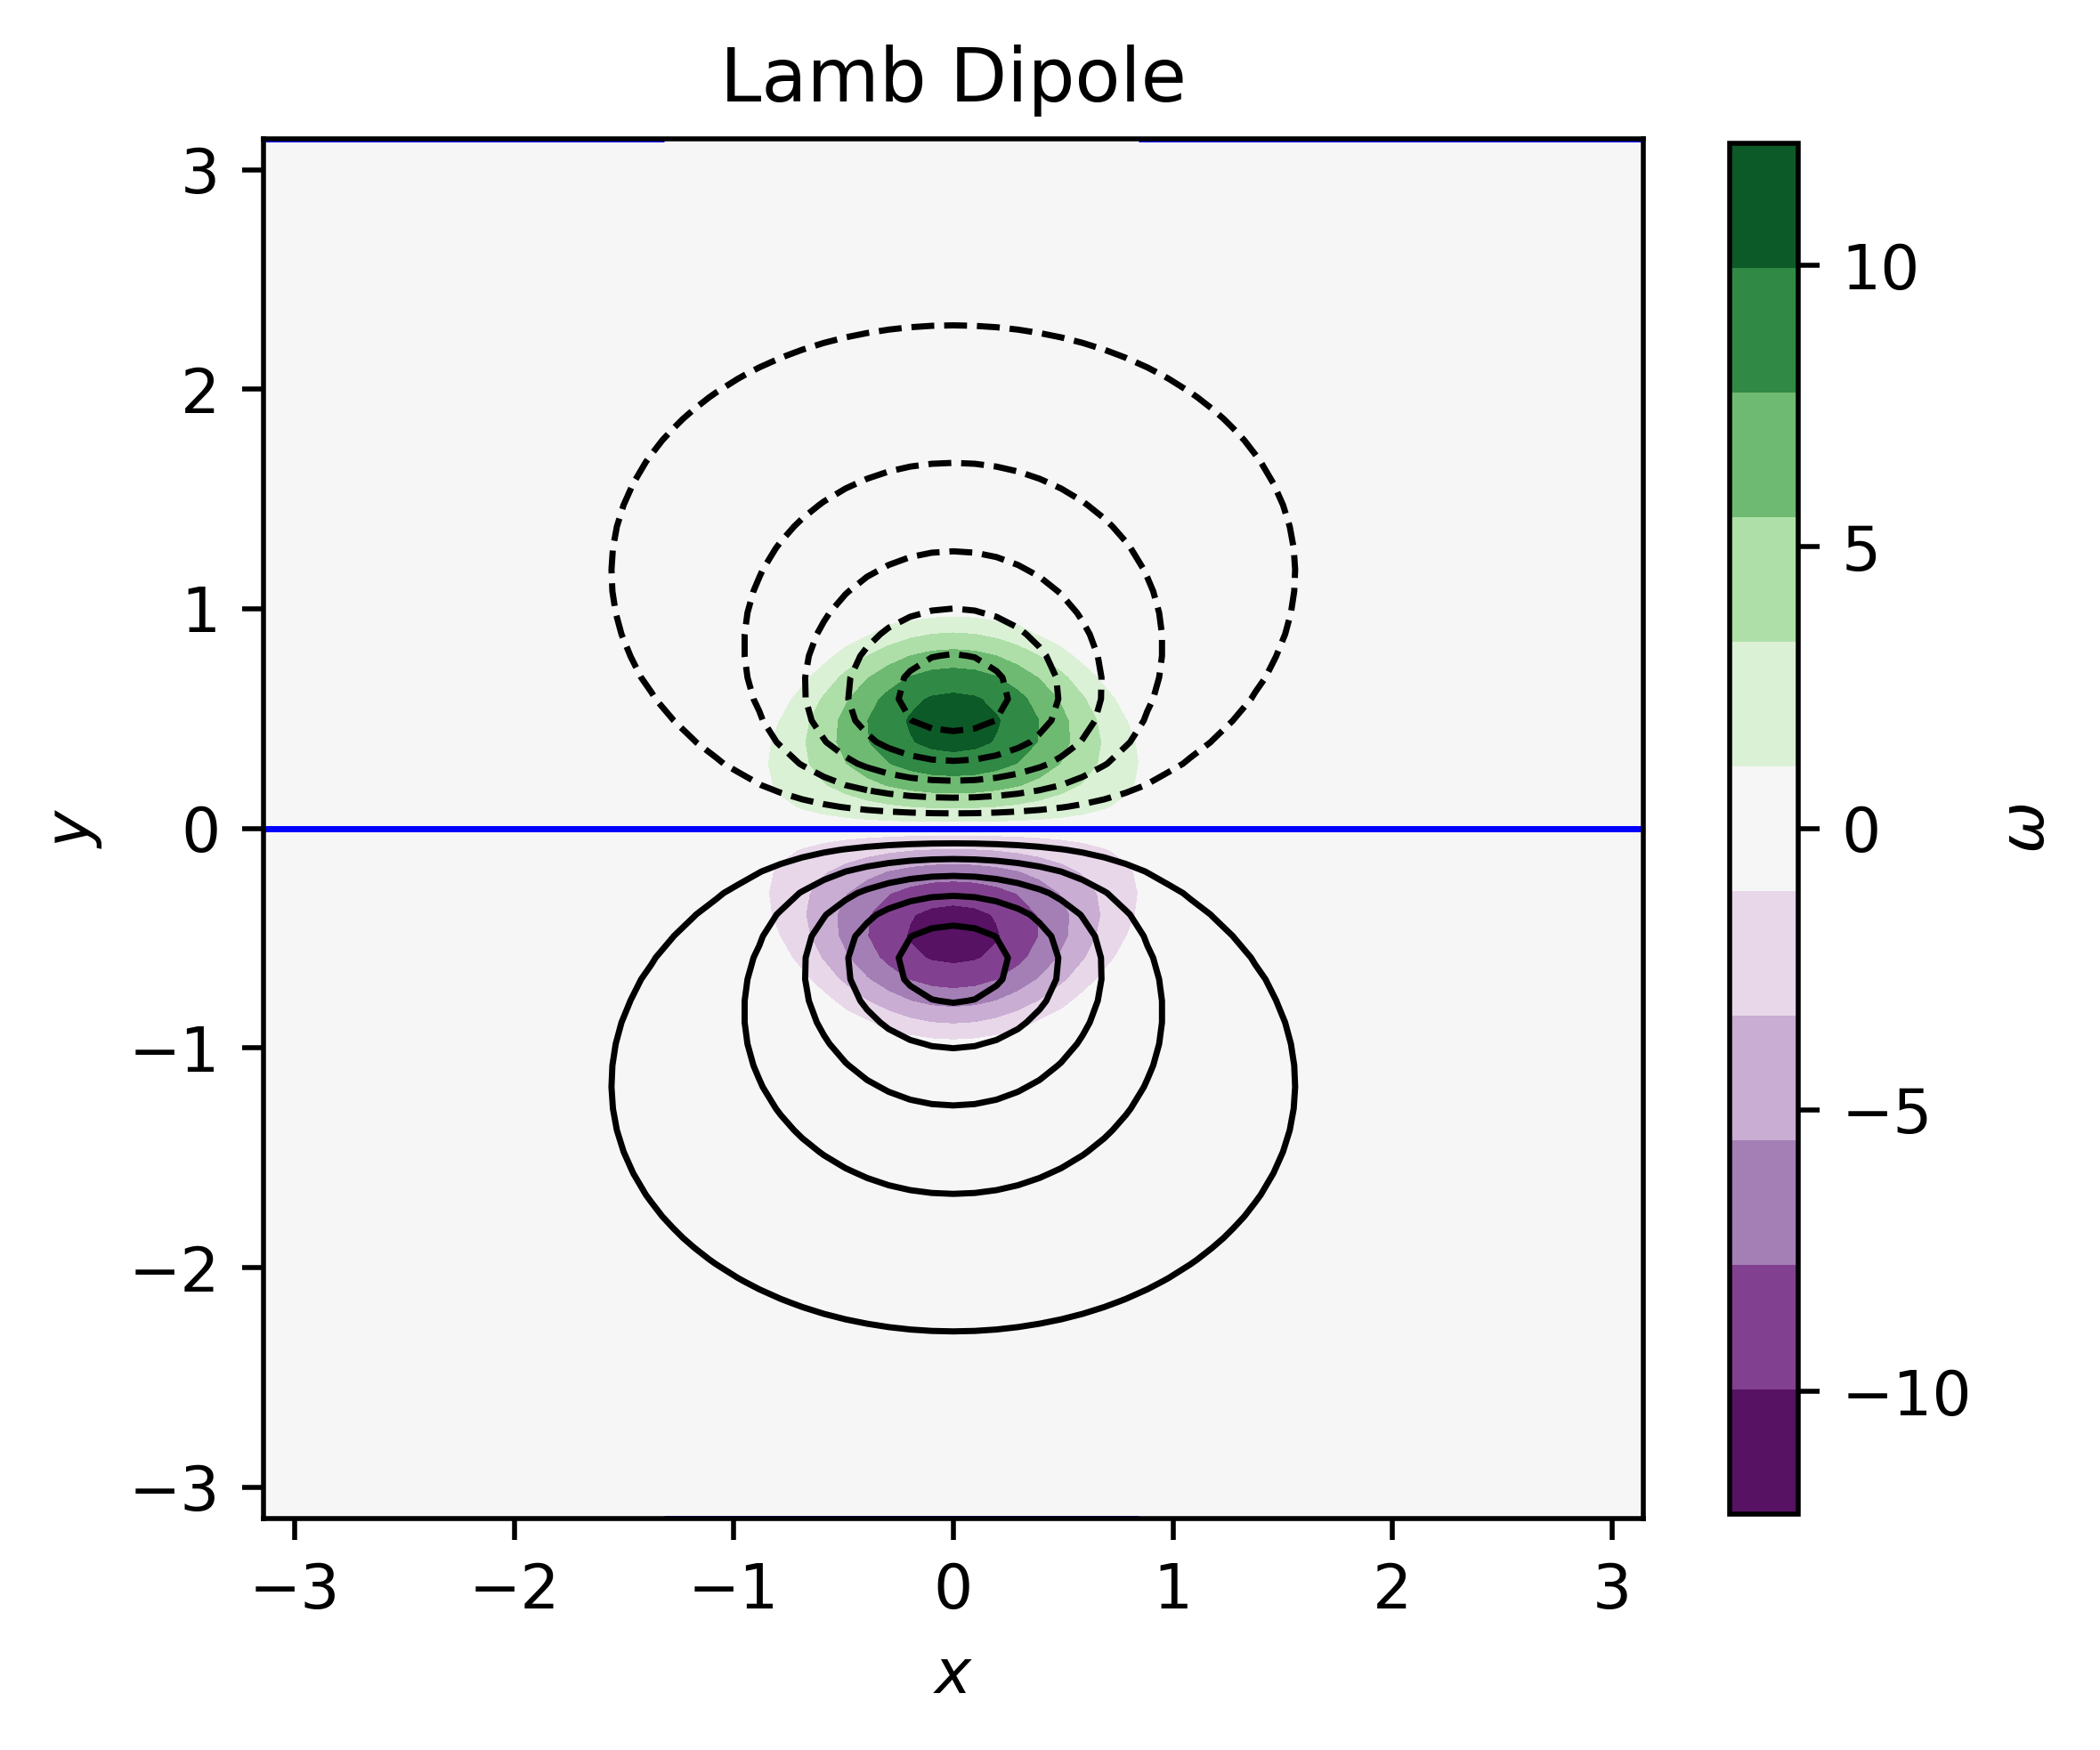

In [2]:
#Lamb Dipole Initial Conditions
N = 64
L = 2*np.pi
Uinf = 0.
om0 = lamb_dipole(Lx=L, Ly=L, Nx=N, Ny=N)

#Include periodic points for plotting
om0_perpnt = np.empty((om0.shape[0]+1,om0.shape[1]+1))
om0_perpnt[:-1, :-1] = om0.real
om0_perpnt[-1,:-1] = om0[0,:].real
om0_perpnt[:-1,-1] = om0[:,0].real
om0_perpnt[-1,-1]  = om0[0,0].real

#Grid with periodic points
x = np.linspace(-L/2, L/2, N+1, endpoint=True)
y = np.linspace(-L/2, L/2, N+1, endpoint=True)
xx, yy = np.meshgrid(x, y)

ommax = np.max(np.abs(om0))*(1.1)

psi = poisson(om0, Lx=L, Ly=L, Nx=N, Ny=N, Uinf=Uinf).real
psi_perpnt = np.empty((psi.shape[0]+1,psi.shape[1]+1))
psi_perpnt[:-1, :-1] = psi
psi_perpnt[-1,:-1] = psi[0,:] - y[0]*Uinf + y[-1]*Uinf
psi_perpnt[:-1,-1] = psi[:,0]
psi_perpnt[-1,-1] =  psi[0,0] - y[0]*Uinf + y[-1]*Uinf

psimax = np.max(np.abs(psi))*(1.1)

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
fig.set_dpi(500)

contf = ax.contourf(xx, yy, om0_perpnt, levels=np.linspace(-ommax, ommax, num=12), cmap='PRGn')
ax.contour(xx, yy, psi_perpnt, levels=np.linspace(0,psimax, num=7)[1:], colors='k', linewidths=1)
ax.contour(xx, yy, psi_perpnt, levels=[0], colors='b', linewidths=1)
ax.contour(xx, yy, psi_perpnt, levels=np.linspace(-psimax, 0, num=7)[:-1], colors='k', linewidths=1)
ax.set_aspect(1.0)
ax.set_xlim(-L/2,L/2)
ax.set_ylim(-L/2,L/2)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_title(r'Lamb Dipole')
fig.colorbar(contf, label=r'$\omega$', shrink=0.8, ticks=(-10, -5, 0, 5, 10))

plt.show()

In [3]:
ani = animation(om0=om0, dt=0.05, Lx=L, Ly=L, Nx=N, Ny=N, Uinf=Uinf, 
                frames=100, delay=2.0, fps=15)
ani.save('./demo_output/lamb_dipole.gif', writer="pillow", fps=15)
plt.close()

![animation](demo_output/lamb_dipole.gif)